# Download and process dataset

In [1]:
!gdown 1oHLZCntGo2RLyD7qzzPEUMJZc1BuSHFh
!unzip -q dogvscat.zip

Downloading...
From (original): https://drive.google.com/uc?id=1oHLZCntGo2RLyD7qzzPEUMJZc1BuSHFh
From (redirected): https://drive.google.com/uc?id=1oHLZCntGo2RLyD7qzzPEUMJZc1BuSHFh&confirm=t&uuid=6f884c21-c5b5-423b-806b-56b133d77a27
To: /content/dogvscat.zip
100% 80.2M/80.2M [00:02<00:00, 39.5MB/s]


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

jitter = 0.1

train_transform = v2.Compose([
    v2.Resize(256, antialias=True),
    v2.RandomCrop(size=(224, 224)),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(),
    v2.ColorJitter(jitter, jitter, jitter),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(256, antialias=True),
    v2.CenterCrop(224),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder("dogvscat/train", transform=train_transform)
valid_dataset = ImageFolder("dogvscat/validation", transform=test_transform)
test_dataset = ImageFolder("dogvscat/test", transform=test_transform)

rng = torch.Generator().manual_seed(42)
train_loader = DataLoader(train_dataset, 32, True, generator=rng)
valid_loader = DataLoader(valid_dataset, 32, True, generator=rng)
test_loader = DataLoader(test_dataset, 32, True, generator=rng)

# Training loop

In [3]:
from tqdm.notebook import tqdm

def evaluate(name, model, loader, loss_fn, metric_fn, device):
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_metric = 0
        pbar = tqdm(valid_loader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.unsqueeze(-1).float().to(device)

            preds = model(images)
            loss = loss_fn(preds, labels)
            metric = metric_fn(preds, labels)

            valid_loss = (valid_loss * i + loss.item()) / (i + 1)
            valid_metric = (valid_metric * i + metric.item()) / (i + 1)
            pbar.set_description(f"[{name}] Loss: {valid_loss:.4f} - Metric: {valid_metric:.4f}")

        return valid_loss, valid_metric


class TrainResult:
    def __init__(self):
        self.train_loss = []
        self.train_metric = []
        self.valid_loss = []
        self.valid_metric = []
        self.best_metric = 0.0


def train(model, train_loader, valid_loader, optimizer, scheduler, loss_fn, metric_fn, epochs, device):
    hist = TrainResult()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}:")
        model.train()
        train_loss = 0
        train_metric = 0
        pbar = tqdm(train_loader)
        for i, (images, labels) in enumerate(pbar):
            optimizer.zero_grad()

            images = images.to(device)
            labels = labels.unsqueeze(-1).float().to(device)

            preds = model(images)
            loss = loss_fn(preds, labels)
            metric = metric_fn(preds, labels)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss = (train_loss * i + loss.item()) / (i + 1)
            train_metric = (train_metric * i + metric.item()) / (i + 1)
            pbar.set_description(f"[Training] Loss: {train_loss:.4f} - Metric: {train_metric:.4f}")
        if scheduler:
            scheduler.step()

        hist.train_loss.append(train_loss)
        hist.train_metric.append(train_metric)

        valid_loss, valid_metric = evaluate("Validation", model, valid_loader, loss_fn, metric_fn, device)
        hist.valid_loss.append(valid_loss)
        hist.valid_metric.append(valid_metric)
        if valid_metric > hist.best_metric:
            hist.best_metric = valid_metric
            hist.best_model = model.state_dict()

    hist.last_model = model.state_dict()
    return hist

# Resnet34

In [4]:
import timm
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = timm.create_model('resnet34.a1_in1k', pretrained=True, num_classes=1)
model = model.to(device)

def accuracy(preds, labels):
    return ((preds >= 0) == labels).float().mean()

num_epochs = 10
adam = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam, T_max=num_epochs)
criterion = nn.functional.binary_cross_entropy_with_logits

hist = train(model, train_loader, valid_loader, adam, scheduler, criterion, accuracy, num_epochs, device)

result_resnet = {
    "train_loss": hist.train_loss,
    "train_metric": hist.train_metric,
    "valid_loss": hist.valid_loss,
    "valid_metric": hist.valid_metric,
}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Classification Report:

              precision    recall  f1-score   support

        cats     0.9764    0.9920    0.9841       250
        dogs     0.9919    0.9760    0.9839       250

    accuracy                         0.9840       500
   macro avg     0.9841    0.9840    0.9840       500
weighted avg     0.9841    0.9840    0.9840       500

Accuracy: 0.9840


(np.float64(0.984),
 array([[248,   2],
        [  6, 244]]))

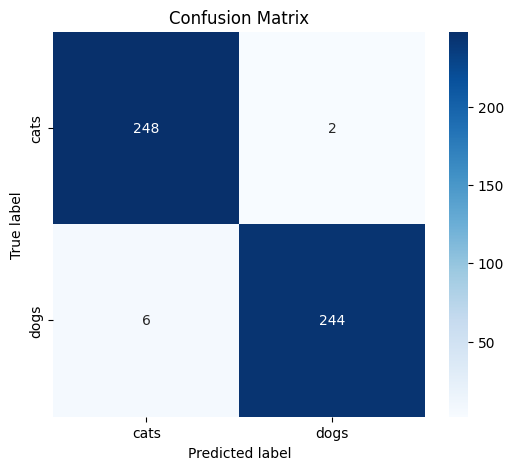

In [5]:
def evaluate_model(model, test_loader, class_names, device):
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix

    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.unsqueeze(-1).float().to(device)

            outputs = model(images)
            preds = outputs > 0

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Classification Report ---
    print("Classification Report:\n")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    ))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.savefig("confusion-matrix.svg")

    # --- Accuracy ---
    accuracy = (y_true == y_pred).mean()
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy, cm

model.load_state_dict(hist.best_model)
evaluate_model(model, test_loader, test_dataset.classes, device)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Test acc (last) = 0.99609375, Test acc (best) = 0.9949218742549419


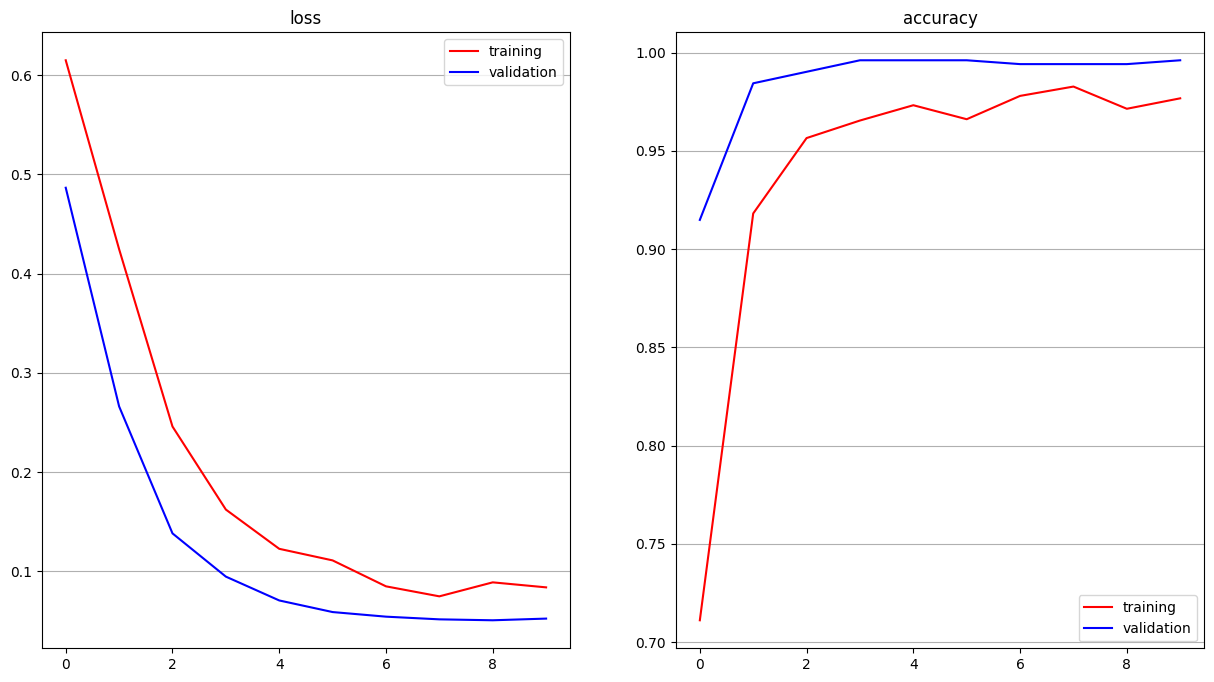

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(range(num_epochs), hist.train_loss, label='training', color='r')
ax[0].plot(range(num_epochs), hist.valid_loss, label='validation', color='b')
ax[0].set_title('loss')
ax[0].legend()
ax[0].grid(axis='y')

ax[1].plot(range(num_epochs), hist.train_metric, label='training', color='r')
ax[1].plot(range(num_epochs), hist.valid_metric, label='validation', color='b')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].grid(axis='y')

model.load_state_dict(hist.last_model)
_, last_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
model.load_state_dict(hist.best_model)
_, best_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
print(f"Test acc (last) = {last_acc}, Test acc (best) = {best_acc}")

# Convmixer

In [7]:
import timm
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = timm.create_model('convmixer_768_32.in1k', pretrained=True, num_classes=1)
model = model.to(device)

def accuracy(preds, labels):
    return ((preds >= 0) == labels).float().mean()

num_epochs = 10
adam = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adam, T_max=num_epochs)
criterion = nn.functional.binary_cross_entropy_with_logits

hist = train(model, train_loader, valid_loader, adam, scheduler, criterion, accuracy, num_epochs, device)

result_convmixer = {
    "train_loss": hist.train_loss,
    "train_metric": hist.train_metric,
    "valid_loss": hist.valid_loss,
    "valid_metric": hist.valid_metric,
}

torch.save(hist.best_model, "model.pt")

model.safetensors:   0%|          | 0.00/84.9M [00:00<?, ?B/s]

Epoch 1/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/10:


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Test acc (last) = 0.994140625, Test acc (best) = 0.994140625


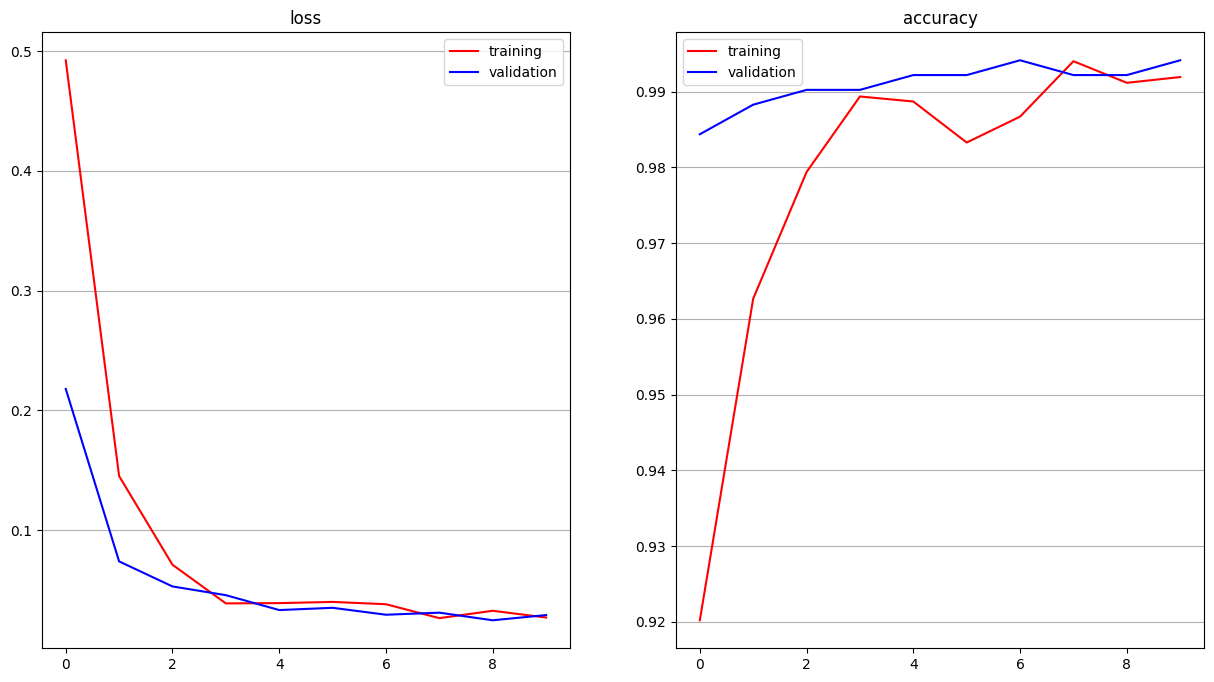

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(range(num_epochs), hist.train_loss, label='training', color='r')
ax[0].plot(range(num_epochs), hist.valid_loss, label='validation', color='b')
ax[0].set_title('loss')
ax[0].legend()
ax[0].grid(axis='y')

ax[1].plot(range(num_epochs), hist.train_metric, label='training', color='r')
ax[1].plot(range(num_epochs), hist.valid_metric, label='validation', color='b')
ax[1].set_title('accuracy')
ax[1].legend()
ax[1].grid(axis='y')

model.load_state_dict(hist.last_model)
_, last_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
model.load_state_dict(hist.best_model)
_, best_acc = evaluate("Test", model, test_loader, criterion, accuracy, device)
print(f"Test acc (last) = {last_acc}, Test acc (best) = {best_acc}")

In [10]:
import json

with open("result.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "result_resnet": result_resnet,
            "result_convmixer": result_convmixer,
        },
        f,
        indent=4
    )


In [12]:
class_names = test_dataset.classes
class_names

['cats', 'dogs']

Classification Report:

              precision    recall  f1-score   support

        cats     0.9920    0.9960    0.9940       250
        dogs     0.9960    0.9920    0.9940       250

    accuracy                         0.9940       500
   macro avg     0.9940    0.9940    0.9940       500
weighted avg     0.9940    0.9940    0.9940       500

Accuracy: 0.9940


(np.float64(0.994),
 array([[249,   1],
        [  2, 248]]))

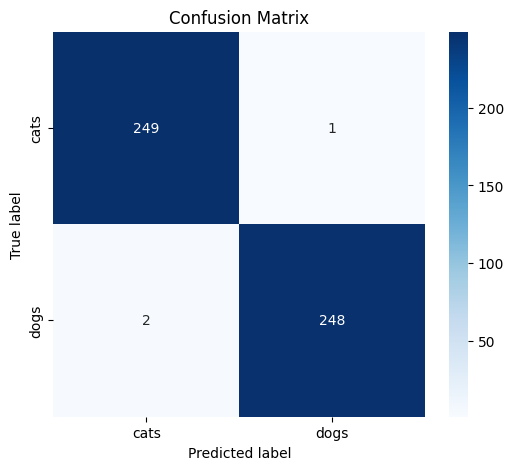

In [13]:
evaluate_model(
    model=model,
    test_loader=test_loader,
    class_names=class_names,
    device=device
)